In [96]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from forecastingGDP.data import get_data
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

### Data

#### Retrieval

In [97]:
df=get_data()

In [98]:
df.shape

(299, 54)

In [99]:
#Starting and ending date
print(f'Start: {df.index[0]}')
print(f'End: {df.index[-1]}')

Start: 1947-01-01 00:00:00
End: 2021-07-01 00:00:00


In [100]:
#Missing Values %
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df=missing_value_df.sort_values('percent_missing',ascending=False)
missing_value_df


,column_name,percent_missing
ATLSBUSRGEP_first_release,ATLSBUSRGEP_first_release,98.662207
DTWEXAFEGS_first_release,DTWEXAFEGS_first_release,96.655518
MARTSMPCSM44000USS_first_release,MARTSMPCSM44000USS_first_release,94.983278
ATLSBUSRGEP,ATLSBUSRGEP,93.979933
IEAXGS_first_release,IEAXGS_first_release,90.635452
IEAMGSN_first_release,IEAMGSN_first_release,90.635452
BAMLH0A0HYM2_first_release,BAMLH0A0HYM2_first_release,90.301003
VIXCLS_first_release,VIXCLS_first_release,90.301003
DGS10_first_release,DGS10_first_release,90.301003
T10Y2Y_first_release,T10Y2Y_first_release,89.632107


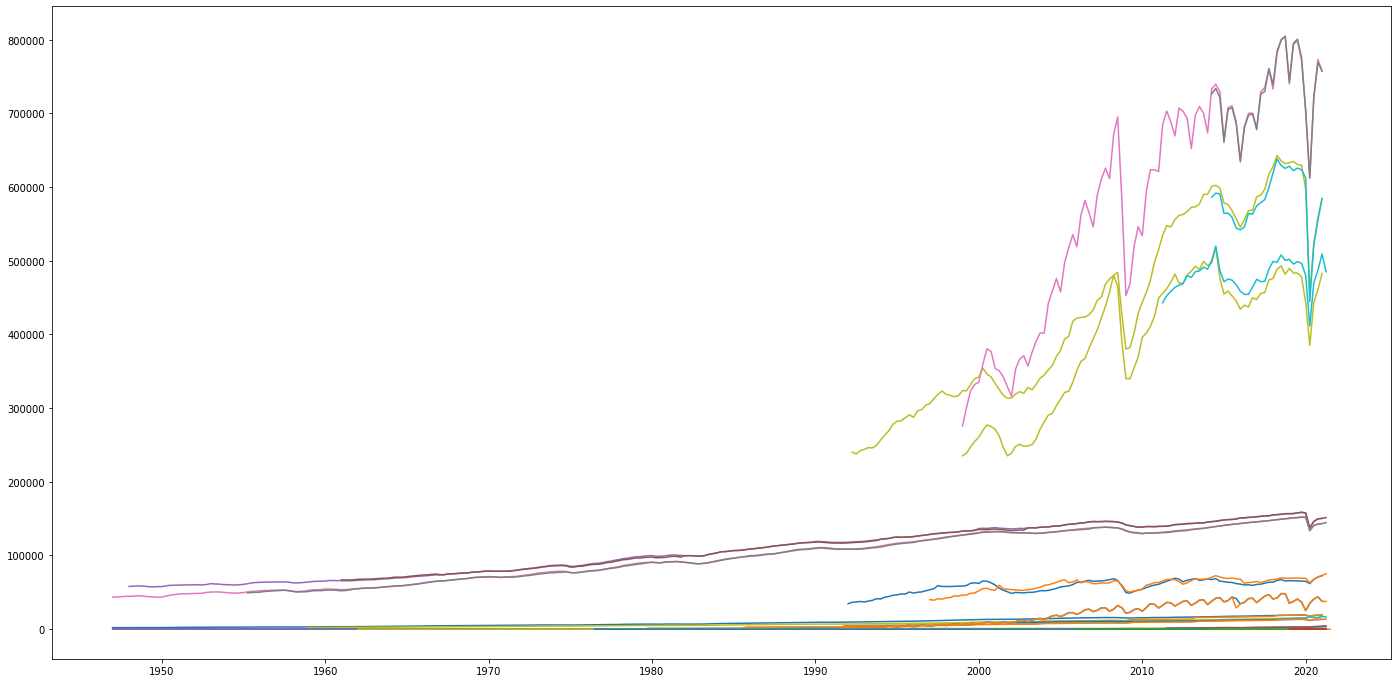

In [101]:
plt.figure(figsize=(24, 12))
plt.plot(df,label=df.columns,);



In [102]:
#Number of NaN in df
df.isnull().sum().sum()

8578

In [103]:
###Test with the most complete features
df=df[['GDPC1','INDPRO', 'PAYEMS','PPIACO']].dropna()

In [161]:
#No Covid Crisis
df=df[:-4]

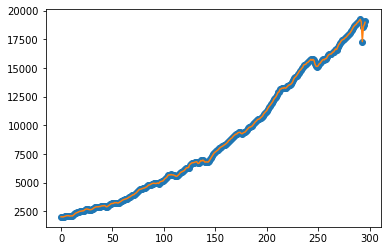

In [156]:
#Interpolation test
X=np.arange(0, 297)
y=df['GDPC1']
f = interp1d(X, y)
xnew = np.arange(0, 296, (1/3))
ynew = f(xnew)
plt.plot(X, y, 'o', xnew, ynew, '-')
plt.show()

In [164]:
ynew

array([ 2033.061     ,  2031.25366667,  2029.44633333,  2027.639     ,
        2026.24333333,  2024.84766667,  2023.452     ,  2034.00233333,
        2044.55266667,  2055.103     ,  2065.40766667,  2075.71233333,
        2086.017     ,  2097.49466667,  2108.97233333,  2120.45      ,
        2124.49933333,  2128.54866667,  2132.598     ,  2133.39233333,
        2134.18666667,  2134.981     ,  2125.17466667,  2115.36833333,
        2105.562     ,  2103.168     ,  2100.774     ,  2098.38      ,
        2105.60133333,  2112.82266667,  2120.044     ,  2114.113     ,
        2108.182     ,  2102.251     ,  2129.79133333,  2157.33166667,
        2184.872     ,  2207.08366667,  2229.29533333,  2251.507     ,
        2280.50933333,  2309.51166667,  2338.514     ,  2353.43966667,
        2368.36533333,  2383.291     ,  2394.08066667,  2404.87033333,
        2415.66      ,  2429.61233333,  2443.56466667,  2457.517     ,
        2474.4       ,  2491.283     ,  2508.166     ,  2510.00733333,
      

#### df_train & df_test split

In [50]:
# Time Serie split 
#We separate df into df_train and df_test such that the first 80% of the dataframe are in the training. 
#And the last 20% in the test set.

len_ = int(0.6*df.shape[0])
df_train = df[:len_]
df_test = df[len_:len_+int(len(df[len_:])/2)]
df_val=df[len_+int(len(df[len_:])/2):]
assert df_train.shape[0]+df_test.shape[0]+df_val.shape[0] == df.shape[0]

In [51]:
# Scale with MinMaxScale so they have the same range
columns = df.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_val=pd.DataFrame(scaler.transform(df_val), columns=columns)
df_train.head()

,GDPC1,INDPRO,PAYEMS,PPIACO
0,0.001303,0.005089,0.004973,0.000000
1,0.000568,0.005270,0.006220,0.002103
2,0.000000,0.005817,0.011028,0.009464
3,0.004292,0.013451,0.018886,0.021030
4,0.008483,0.016360,0.020989,0.027340


In [52]:
df_train.shape

(178, 4)

In [53]:
df_test.shape

(59, 4)

In [54]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample


def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['GDPC1']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [135]:
#Sequences has to be >100 for our model to train correclty
X_train, y_train = get_X_y(df_train, 290, 4)
print(X_train.shape)
print(y_train.shape)

(290, 3, 4)
(290,)


In [136]:
X_test, y_test = get_X_y(df_test, 30, 4)
print(X_test.shape)
print(y_test.shape)

(30, 3, 4)
(30,)


In [137]:
X_val, y_val = get_X_y(df_val, 50, 4)
print(X_val.shape)
print(y_val.shape)

(50, 3, 4)
(50,)


In [138]:
input_shape=X_train[0].shape

### RNN MODEL

In [139]:
# Mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : 69.80 %


In [140]:
# Predict MAPE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : 1.09 %


In [141]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline-y_test))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

Benchmark MAE on the test set : 0.9557


In [142]:
# Predict MAE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test))
print(f'Benchmark MAE on the test set : {bench_res:.2f} %')

Benchmark MAE on the test set : 0.01 %


In [143]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

Benchmark RMSE on the test set : 0.9833


In [144]:
# Predict RMSE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

Benchmark RMSE on the test set : 0.0162


In [145]:
input_shape=X_train.shape[1:]
input_shape

(3, 4)

In [170]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.LSTM(20, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mean_squared_logarithmic_error', 
                  optimizer='rmsprop', 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 3, 20)             2000      
_________________________________________________________________
lstm_49 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_54 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 6         
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#grid search test
# create model
model = init_model()
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

In [171]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=10,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=16,
            verbose=0,
            callbacks=[es])

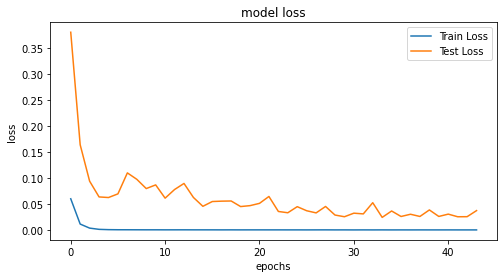

In [172]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [173]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.0840
MAPE on the test set: 5.4089
RMSE on the test set: 0.2898


In [174]:
y_pred=model.predict(X_test)

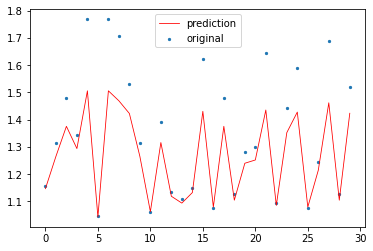

In [175]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()

In [163]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.GRU(20, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.GRU(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 3, 20)             1560      
_________________________________________________________________
gru_5 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 6         
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=10,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=32,
            verbose=0,
            callbacks=[es])

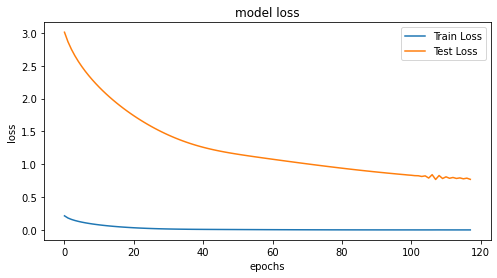

In [32]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [33]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.3337
MAPE on the test set: 21.6487
RMSE on the test set: 0.5777


In [34]:
y_pred=model.predict(X_test)

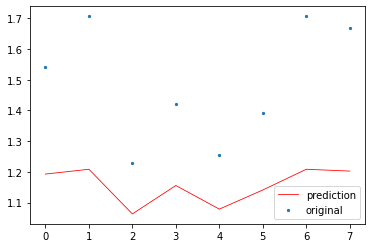

In [35]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()